# Testing and checking of MAG data and pitch angle calculation in space craft reference frame

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import load_nom_II as ld
import plot_nom_II as pt
import time
from cdflib import CDF, cdfepoch
from mag import MAGdata

Loading data:

In [10]:
period =(dt.datetime(2021,12,4,13,50),dt.datetime(2021,12,4,14,30))

dat_srf = CDF(path='data/mag/2021/srf/solo_L2_mag-srf-normal_20211204_V01.cdf')
time_srf = dat_srf.varget('EPOCH')
mag_srf_uncut = dat_srf.varget('B_SRF').T
mag_srf = []

t = cdfepoch.encode_tt2000(time_srf)
time_srf = []
for tt in t:
    time_srf.append(dt.datetime.fromisoformat(str(tt)[:26]))
time_srf = np.array(time_srf)

mask = (period[0] <= time_srf) * (time_srf < period[1])
time_srf = time_srf[mask]
for i in range(3):
    mag_srf.append(mag_srf_uncut[i][mask])


dat_rtn = CDF('data/mag/2021/rtn/solo_L2_mag-rtn-normal-1-minute_20211204_V01.cdf')
time_rtn = dat_rtn.varget('EPOCH')
mag_rtn_uncut = dat_rtn.varget('B_RTN').T
mag_rtn = []

t = cdfepoch.encode_tt2000(time_rtn)
time_rtn = []
for tt in t:
    time_rtn.append(dt.datetime.fromisoformat(str(tt)[:26]))
time_rtn = np.array(time_rtn)

mask = (period[0] <= time_rtn) * (time_rtn < period[1])
time_rtn = time_rtn[mask]
for i in range(3):
    mag_rtn.append(mag_rtn_uncut[i][mask])

Calculating pitch angles:

In [21]:
# field of view der Pixel (Phi, Theta) #

fov = np.array([[-25,24],[-25,12],[-25,0],[-25,-12],[-25,-24],[-35,24],[-35,12],[-35,0],[-35,-12],[-35,-24],[-45,24],[-45,12],[-45,0],[-45,-12],[-45,-24]])

def calc_angles_rtn(B_R,B_T,B_N):
    '''Winkel der Magnetfeldvektoren in Radians im Spacecraft-Frame aus RTN'''
    phi = np.arctan2(B_T,B_R)
    theta = np.arctan2(B_N,np.sqrt(B_T**2+B_R**2))
    return phi, theta

def calc_angles_srf(B_X,B_Y,B_Z):
    '''Winkel der Magnetfeldvektoren in Radians im Spacecraft-Frame aus SRF'''
    phi = np.arctan2(B_Y,B_X)
    theta = np.arctan2(B_Z,np.sqrt(B_Y**2+B_X**2))
    return phi, theta

def pw_srf(v_phi,v_theta,B_phi,B_theta):
    v_theta = np.radians(v_theta)
    v_phi = np.radians(v_phi)
    B_theta = np.radians(B_theta)
    B_phi = np.radians(B_phi)
    argument = np.cos(v_theta)*np.cos(v_phi)*np.cos(B_theta)*np.cos(B_phi) + np.cos(v_theta)*np.sin(v_phi)*np.cos(B_theta)*np.sin(B_phi) + np.sin(v_theta)*np.sin(B_theta)
    # if argument > 1.0 and v_theta == B_theta and v_phi == B_phi:
    #     argument = 1.0
    pitchangle = np.degrees(np.arccos(argument))
    return pitchangle

        
def pw_rtn(v_phi,v_theta,B_phi,B_theta):
    '''Es ist wichtig die Normierung zu beachten. Wenn ich die RTN-Koordinaten über die Winkel beschreibe, kann ich die Vorfaktoren 1 setzen.
     Numpy nimmt die Winkel in Radians. Muss den Spezialfall von Werten größer 1 im arccos abfangen Dieser Sonderfall ist hier erstmal ignoriert. 
    Für das Magnetfeld, werden die Daten des Objekts genommen.
    Der Winkel \phi gibt die Drehung in der RT-Ebene und \theta in der RN-Ebene.
    Für die Umrechnung müsste mit v als Länge des Vektors gelten:
        R = v*cos(phi)*cos(theta)
        T = v*sin(phi)*cos(theta)
        N = v*sin(theta)
    Die Attribute phi und theta beziehen sich bei Lars auf das Magnetfeld.'''
    v_theta = np.radians(v_theta)
    v_phi = np.radians(v_phi)
    B_theta = np.radians(B_theta)
    B_phi = np.radians(B_phi)
    argument = np.cos(v_theta)*np.cos(v_phi)*np.cos(B_theta)*np.cos(B_phi) + np.cos(v_theta)*np.sin(v_phi)*np.cos(B_theta)*np.sin(B_phi) + np.sin(v_theta)*np.sin(B_theta)
    # if argument > 1.0 and v_theta == B_theta and v_phi == B_phi:
    #     argument = 1.0
    pitchangle = np.degrees(np.arccos(argument))
    return pitchangle



phi_srf, theta_srf = calc_angles_srf(mag_srf[0],mag_srf[1],mag_srf[2])
phi_rtn, theta_rtn = calc_angles_rtn(mag_rtn[0],mag_rtn[1],mag_rtn[2])

print(mag_srf[1]/mag_srf[0])
print(mag_rtn[1]/mag_rtn[0])
print(np.arctan2(mag_srf[1],mag_srf[0]))
print(np.arctan2(mag_rtn[1],mag_rtn[0]))

[-0.4742686  -0.47813952 -0.48142517 ... -0.11614543 -0.11338541
 -0.11036576]
[-0.5090453  -0.4328602  -0.45041552 -0.5332527  -0.27757955 -0.3804956
 -0.35151696 -0.1026512  -0.09654777 -0.1347409  -0.15498622 -0.12076982
 -0.10319175 -0.07530231 -0.10397083 -0.08828361 -0.08485695 -0.1735938
 -0.16226415 -0.18022974 -0.16763371 -0.15617698 -0.20416185 -0.16770047
 -0.1816978  -0.15199068 -0.27581936 -0.19620694 -0.58526164 -0.42912057
 -0.28358465 -0.5384157  -0.3231441  -0.1611886  -0.1785814  -0.17386627
 -0.17936097 -0.14531797 -0.10748242 -0.10877064]
[2.6987412 2.695586  2.692915  ... 3.0259652 3.0286894 3.0316718]
[-0.47085762 -0.40850943 -0.42319942 -0.48989457 -0.2707628  -0.36358002
 -0.33802557 -0.10229291 -0.09624945 -0.13393426 -0.15376285 -0.12018775
 -0.10282779 -0.07516046 -0.1035986  -0.08805532 -0.08465414 -0.17188093
 -0.16086212 -0.17831546 -0.16608943 -0.15492547 -0.20139411 -0.16615437
 -0.17973697 -0.15083626 -0.26912782 -0.19374575 -0.529512   -0.40535563
 -0.

Cutting unreasonable values:

In [18]:
mask = phi_srf > 0
time_srf = time_srf[mask]
mag_srf[0] = mag_srf[0][mask]
mag_srf[1] = mag_srf[1][mask]
mag_srf[2] = mag_srf[2][mask]
phi_srf = phi_srf[mask]
theta_srf = theta_srf[mask]

Plotting:

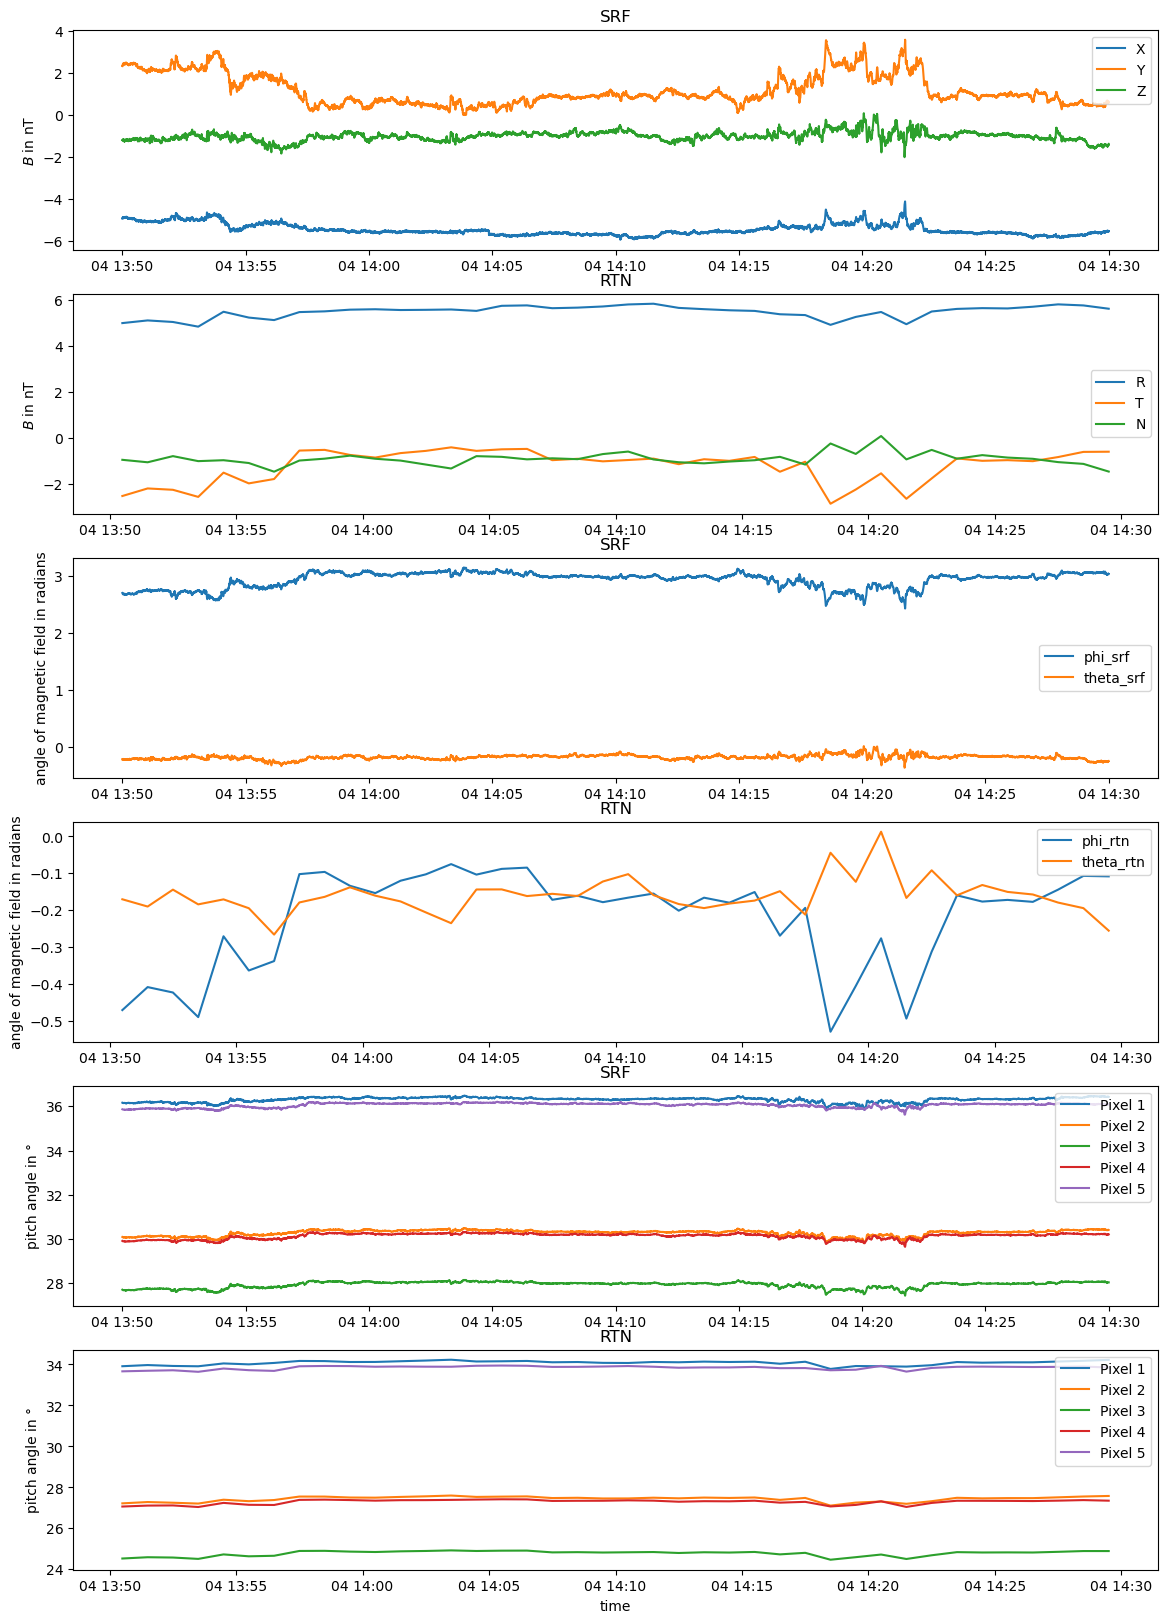

In [19]:
fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(6,1,figsize=(14,20))

labels_srf = ['X','Y','Z']
labels_rtn = ['R','T','N']

for i, mag_component in enumerate(mag_srf):
    ax1.plot(time_srf,mag_component,label=labels_srf[i])

for i, mag_component in enumerate(mag_rtn):
    ax2.plot(time_rtn,mag_component,label=labels_rtn[i])

ax1.set_title('SRF')
ax2.set_title('RTN')
ax1.set_ylabel('$B$ in nT')
ax2.set_ylabel('$B$ in nT')
ax1.legend()
ax2.legend()


ax3.plot(time_srf,phi_srf,label='phi_srf')
ax3.plot(time_srf,theta_srf,label='theta_srf')
ax4.plot(time_rtn,phi_rtn,label='phi_rtn')
ax4.plot(time_rtn,theta_rtn,label='theta_rtn')


ax3.set_title('SRF')
ax4.set_title('RTN')
ax3.set_ylabel('angle of magnetic field in radians')
ax4.set_ylabel('angle of magnetic field in radians')
ax3.legend()
ax4.legend()


for i in range(1,6):
    ax5.plot(time_srf,pw_srf(fov[i-1][0],fov[i-1][1],phi_srf,theta_srf),label=f'Pixel {i}')
    ax6.plot(time_rtn,pw_rtn(fov[i-1][0],fov[i-1][1],phi_rtn,theta_rtn),label=f'Pixel {i}')


ax5.set_title('SRF')
ax6.set_title('RTN')
ax5.set_ylabel('pitch angle in °')
ax6.set_ylabel('pitch angle in °')
ax5.legend()
ax6.legend()

ax6.set_xlabel('time')


plt.savefig('pw_srf/comparison_mag_data.png')